# OpenAI API Integration Setup

In [1]:
import openai
from openai import OpenAI
from dotenv import load_dotenv
from pathlib import Path
import os
import re
import warnings

In [2]:
# Load .env file
load_dotenv()

True

In [3]:
def generate_chat_completion(client, messages):    
    try:
        completion = client.chat.completions.create(messages = messages, model = "gpt-3.5-turbo") # replace with desired model
        return completion.choices[0].message.content

    except openai.APIConnectionError as e:
        print("The server could not be reached")
        print(e.__cause__)  # an underlying Exception, likely raised within httpx.
    except openai.RateLimitError as e:
        print("A 429 status code was received; we should back off a bit.")
    except openai.APIStatusError as e:
        print("Another non-200-range status code was received")
        print(e.status_code)
        print(e.response)
        

def extract_python_code(input_string):
    # Regular expression pattern to match code blocks
    pattern = r"```python(.*?)```"

    # Find all matches of the pattern in the input string
    matches = re.findall(pattern, input_string, re.DOTALL)

    # Concatenate the matches with a newline
    concatenated_code = '\n'.join(match.strip() for match in matches)

    return concatenated_code


def get_conversation_response(client, prompt, messages, python = True):
    conversation = messages + [{"role": "user", "content": prompt}]
    # Get GPT response and append to conversation
    response = generate_chat_completion(client, conversation)
    conversation = conversation + [{"role": "system", "content": response}]
    
    if python: # false if no python output expected
        python_code = extract_python_code(response)
        print(python_code)
        return conversation, python_code
    return conversation, response

# Analyze scRNA-Seq Data using GPT API

Process input arguments and initiate conversation with OpenAI API.

In [4]:
save_figures = True
save_dataframes = True

def process_args(fig_bool, df_bool):
    if fig_bool:
        fig_str = "Visualize, display, and save figures using Scanpy function."
    else:
        fig_str = ""
    
    if df_bool:
        df_str = "Save the DataFrame to the 'tables' folder of the current directory. Then, view the DataFrame."
    else:
        df_str = ""

    return fig_str, df_str

figures_string, dataframes_string = process_args(save_figures, save_dataframes)

In [5]:
role = OpenAI(api_key = os.environ.get("OPENAI_API_KEY"))
conversation_history = []

# Replace 'context' with key information on scRNA-Seq samples
context = "We will be working with two samples that were processed with 10X CellRanger. The samples are gene expression data of 5,000 A549 lung carcinoma cells. These cells, not treated with any external agents, were transduced with a CRISPR pool containing specific sgRNAs. The matrix data represents the expression levels of various genes in each cell, reflecting the genetic landscape and the impact of CRISPR-mediated genetic modifications."
initial_prompt = f"{context} For the rest of our conversation, generate Python code for each task on the analysis of the scRNA-Seq data. Do not provide alternative methods. Your outputs should exclude any examples usages, explanations or comments about the code, except for necessary in-line Python comments. Ask me for the first task."

conversation_history, content = get_conversation_response(role, initial_prompt, conversation_history, python = False)
content

'What is the first task?'

## Load required packages

In [5]:
task1 = "Please load the required packages for the downstream analysis and visualization of scRNA-Seq data using Scanpy. Do not help me install the packages."

conversation_history, response1 = get_conversation_response(role, task1, conversation_history)
exec(response1)

import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Load scRNA-Seq data and Merge the datasets

In [6]:
# Replace directory paths
dir1 = "data/lung_treatment/filtered_feature_bc_matrix"
dir2 = "data/lung_control/filtered_feature_bc_matrix"

task2 = f"Read in the samples located in the '{dir1}' and '{dir2}' directories. Then, merge the datasets and annotate the samples. Do not enforce unique indices during the concatenation."

conversation_history, response2 = get_conversation_response(role, task2, conversation_history)
exec(response2)

import pandas as pd
import scanpy as sc

# Read in the samples
lung_treatment = sc.read_10x_mtx('data/lung_treatment/filtered_feature_bc_matrix')
lung_control = sc.read_10x_mtx('data/lung_control/filtered_feature_bc_matrix')

# Merge the datasets
merged = lung_treatment.concatenate(lung_control, join='outer', index_unique=None)

# Annotate the samples
merged.obs['status'] = ['treatment'] * lung_treatment.shape[0] + ['control'] * lung_control.shape[0]


## Data Preprocessing

Remove cells with too few genes or too many genes, and genes detected in too few cells. Normalize the gene expression measurements to account for differences in sequencing depth. Log-transform the data for downstream analysis.

In [7]:
task3 = "Perform basic preprocessing, including filtering and calculating QC metrics. Normalize the data and perform logarithmic scaling."

conversation_history, response3 = get_conversation_response(role, task3, conversation_history)
exec(response3)

# Filter out low-quality cells and genes
sc.pp.filter_cells(merged, min_genes=200)
sc.pp.filter_genes(merged, min_cells=3)

# Calculate QC metrics
sc.pp.calculate_qc_metrics(merged)

# Normalize the data
sc.pp.normalize_total(merged, target_sum=1e4)

# Logarithmic scaling
sc.pp.log1p(merged)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Identifying Highly Variable Genes

Select genes that show high variation across cells, which are often the most informative for clustering.

# Identify highly variable genes
sc.pp.highly_variable_genes(merged, flavor='seurat', n_top_genes=2000)

# Visualize highly variable genes
sc.pl.highly_variable_genes(merged, save='_highly_variable_genes.png')

# Display and save figure
sc.pl.highest_expr_genes(merged, n_top=20, save='_highest_expr_genes.png')


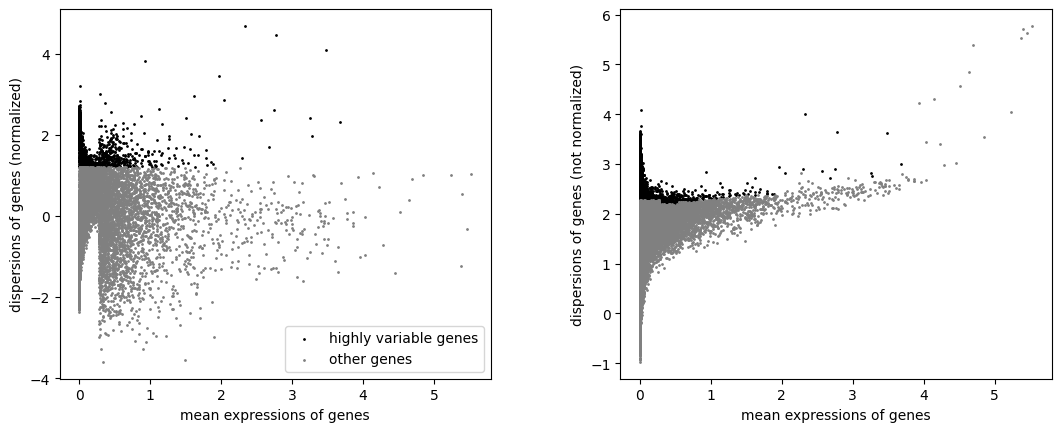

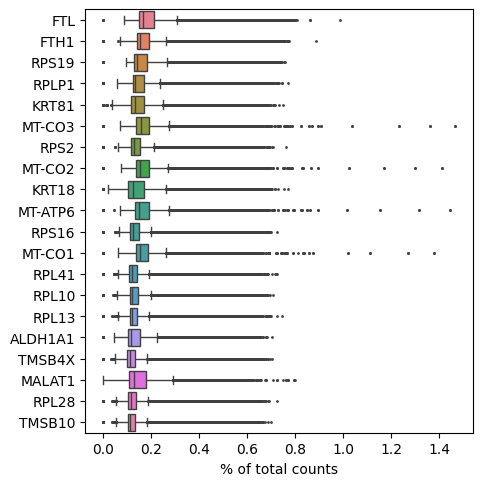

In [8]:
task4 = f"Identify the highly variable genes using an appropriate flavor. {figures_string} Do not save PCA results as a data file."

conversation_history, response4 = get_conversation_response(role, task4, conversation_history)
exec(response4)

## Data Scaling and Dimensionality Reduction

Scale the data to have zero mean and unit variance. Perform Principal Component Analysis (PCA).

In [9]:
task5 = f"Scale the data and perform dimensionality reduction."

conversation_history, response5 = get_conversation_response(role, task5, conversation_history)
exec(response5)

# Scale the data
sc.pp.scale(merged)

# Perform dimensionality reduction
sc.pp.pca(merged)


## Clustering and Visualization

Run clustering algorithms to identify distinct groups of cells.

# Prepare the data for clustering
sc.pp.neighbors(merged)
sc.tl.umap(merged)

# Perform clustering
sc.tl.leiden(merged, resolution=0.1)

# Visualize cluster relationships
sc.pl.umap(merged, color='leiden', save='_clustering.png')


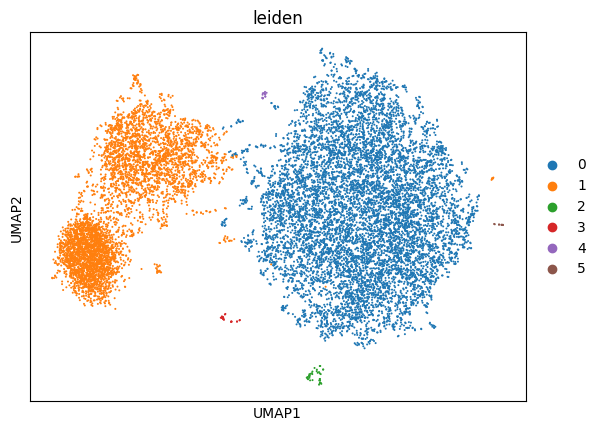

In [10]:
task6 = f"Ensure appropriate processing to prepare for clustering and visualization. Perform clustering with low resolution and visualize cluster relationships. {figures_string)."

conversation_history, response6 = get_conversation_response(role, task6, conversation_history)
exec(response6)

## Find Marker Genes

Identifying marker genes to enhance visualization of distinct cellular populations.

import scanpy as sc
import pandas as pd

# Set the number of marker genes to display per cluster
top_n_marker_genes = 10

# Rank marker genes and plot the top N marker genes for each cluster
sc.tl.rank_genes_groups(adata=merged, groupby='leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata=merged, n_genes=top_n_marker_genes, save='_marker_genes.png')

# Convert marker genes results to DataFrame
results_df = pd.DataFrame(merged.uns['rank_genes_groups']['names'])

# Save the DataFrame to the 'tables' folder
results_df.to_csv('tables/marker_genes_per_cluster.csv', index=False)

# View the DataFrame
print(results_df)


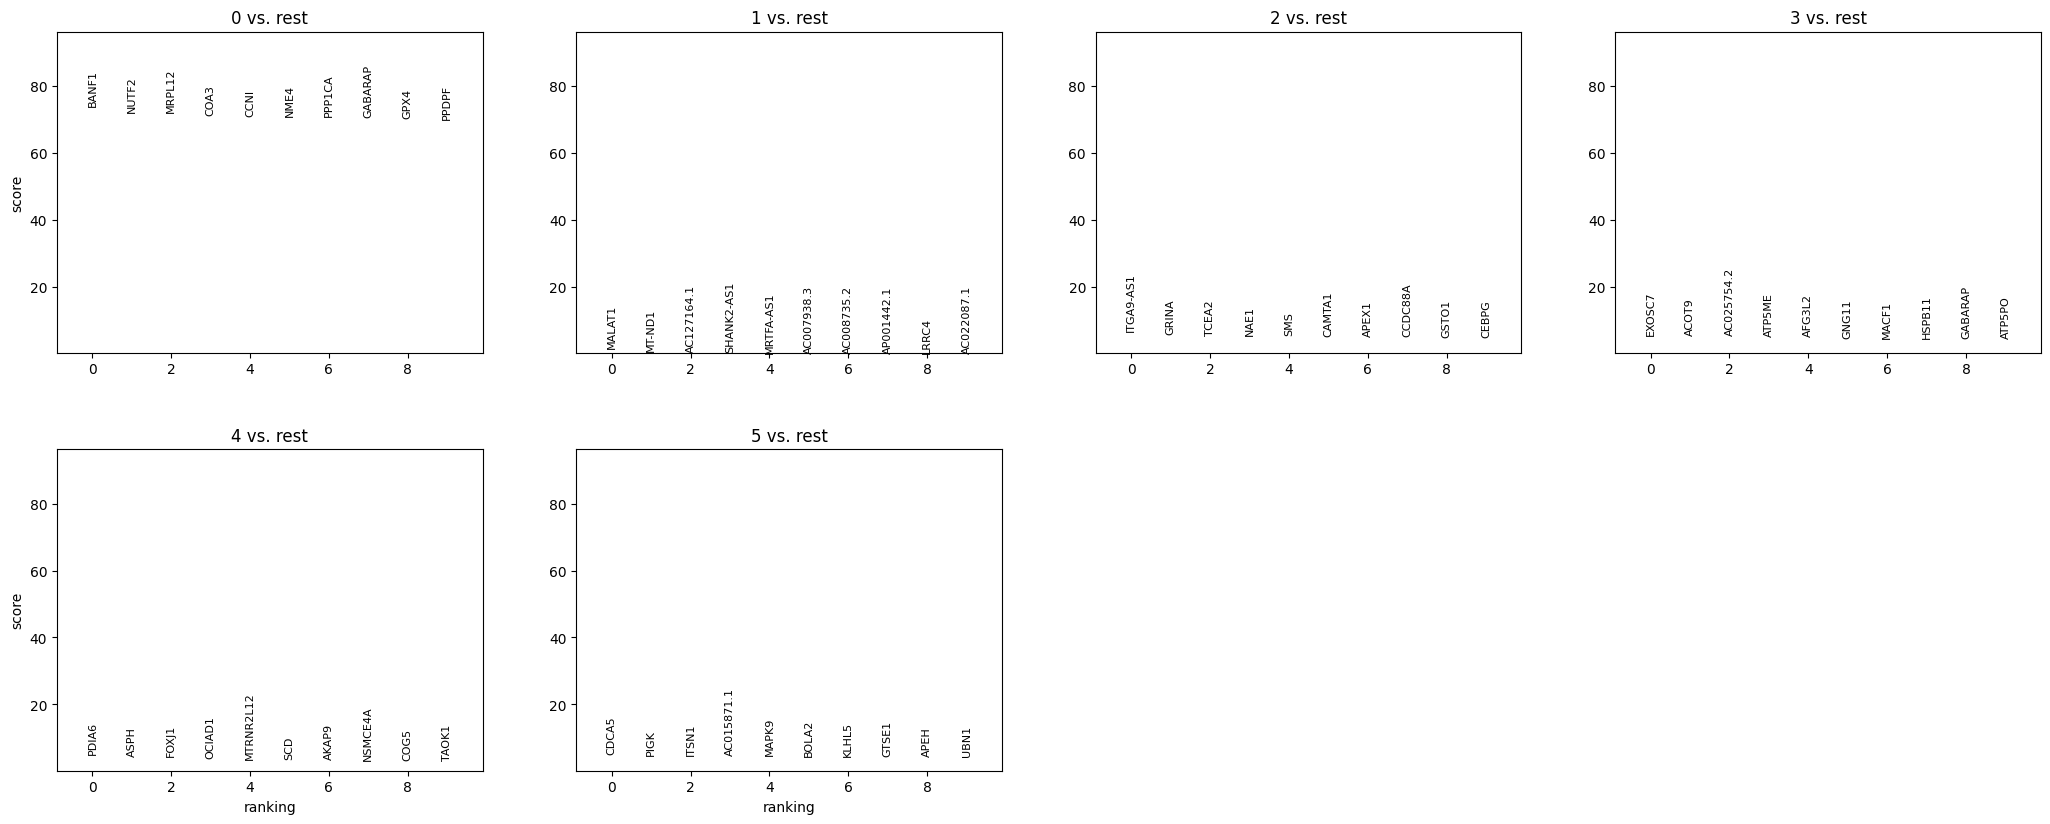

                0           1          2           3          4           5
0           BANF1      MALAT1  ITGA9-AS1      EXOSC7      PDIA6       CDCA5
1           NUTF2      MT-ND1      GRINA       ACOT9       ASPH        PIGK
2          MRPL12  AC127164.1      TCEA2  AC025754.2      FOXJ1       ITSN1
3            COA3  SHANK2-AS1       NAE1      ATP5ME     OCIAD1  AC015871.1
4            CCNI   MRTFA-AS1        SMS      AFG3L2  MTRNR2L12       MAPK9
...           ...         ...        ...         ...        ...         ...
21469  AC025754.2     GABARAP      EMC10      BNIP3L     CAPNS1       RPS23
21470  SHANK2-AS1        COA3       CMC2    DYNC1LI1     MYL12B         VIM
21471  AC127164.1       NUTF2        FTL       RRAGA       MYL6    LGALS3BP
21472      MT-ND1      MRPL12      KRT18       NUMA1     NDUFB2      LGALS3
21473      MALAT1       BANF1       IDH2        MTLN      RPL13         GRN

[21474 rows x 6 columns]


In [11]:
task7 = f"Rank the marker gene and plot the top N marker genes for each cluster, using the same key. {figures_string} Then, convert and show the top N marker genes per cluster as a 'results_df' DataFrame. {dataframes_string}"

conversation_history, response7 = get_conversation_response(role, task7, conversation_history)
exec(response7)

## Identify Cell Types

Identify and confirm the cell types associated with each cluster by examining canonical markers, providing validation of the cellular identities within the clusters.

In [12]:
rank_genes_string = results_df.head().to_string()
task8 = f"Provided below is a table (enclosed in single quotes) of the top 5 marker genes for each cluster. The rows are separated by newlines, and the columns represent the clusters. Deduce and characterize, to the best of your abilities, the potential cell types associated with each cluster. Provide a shorthand name for each cluster describing its potential cell type. '{rank_genes_string}'"

conversation_history, response8 = get_conversation_response(role, task8, conversation_history, python = False)
print(response8)

Based on the provided marker gene table, we can make potential cell type associations for each cluster:

Cluster 0: BANF1, NUTF2, MRPL12, COA3, CCNI
- Potential cell type: Mitochondrial-associated cells (based on marker genes involved in mitochondrial functions)

Cluster 1: MALAT1, MT-ND1, AC127164.1, SHANK2-AS1, MRTFA-AS1
- Potential cell type: Long non-coding RNA (lncRNA) expressing cells (based on marker genes associated with lncRNA)

Cluster 2: ITGA9-AS1, GRINA, TCEA2, NAE1, SMS
- Potential cell type: Transcriptionally active cells (based on marker genes involved in transcriptional activity)

Cluster 3: EXOSC7, ACOT9, AC025754.2, ATP5ME, AFG3L2
- Potential cell type: Metabolic active cells (based on marker genes involved in metabolism)

Cluster 4: PDIA6, ASPH, FOXJ1, OCIAD1, MTRNR2L12
- Potential cell type: Secretory cells (based on marker genes involved in protein folding and secretion)

Cluster 5: CDCA5, PIGK, ITSN1, AC015871.1, MAPK9
- Potential cell type: Cell cycle and prolife

In [14]:
task9 = f"Using the output above, create a DataFrame of clusters, top marker genes, and the identified cell types. {dataframes_string} Finally, create a new column in the observations of the original data, containing the identified cell types by using the cluster to cell type mapping. Ensure the cluster numbers are a string not numerical when mapping."

conversation_history, response9 = get_conversation_response(role, task9, conversation_history)
exec(response9)

import pandas as pd

# Define the cluster to cell type mapping
cluster_cell_type_mapping = {
    '0': 'Mitochondrial-associated cells',
    '1': 'Long non-coding RNA expressing cells',
    '2': 'Transcriptionally active cells',
    '3': 'Metabolic active cells',
    '4': 'Secretory cells',
    '5': 'Cell cycle and proliferation cells'
}

# Create DataFrame of clusters, top marker genes, and cell types
cluster_marker_genes = {
    'Cluster': ['0', '1', '2', '3', '4', '5'],
    'Marker Genes': [
        'BANF1, NUTF2, MRPL12, COA3, CCNI',
        'MALAT1, MT-ND1, AC127164.1, SHANK2-AS1, MRTFA-AS1',
        'ITGA9-AS1, GRINA, TCEA2, NAE1, SMS',
        'EXOSC7, ACOT9, AC025754.2, ATP5ME, AFG3L2',
        'PDIA6, ASPH, FOXJ1, OCIAD1, MTRNR2L12',
        'CDCA5, PIGK, ITSN1, AC015871.1, MAPK9'
    ],
    'Cell Type': [cluster_cell_type_mapping[str(i)] for i in range(6)]
}

# Create the DataFrame
cluster_df = pd.DataFrame(cluster_marker_genes)

# Save the DataFrame to the 'tables' folder
clu

# Define a dictionary of known canonical markers for each cell type
canonical_markers = {
    'Mitochondrial-associated cells': ['BANF1', 'NUTF2', 'MRPL12', 'COA3', 'CCNI'],
    'Long non-coding RNA expressing cells': ['MALAT1', 'MT-ND1', 'AC127164.1', 'SHANK2-AS1', 'MRTFA-AS1'],
    'Transcriptionally active cells': ['ITGA9-AS1', 'GRINA', 'TCEA2', 'NAE1', 'SMS'],
    'Metabolic active cells': ['EXOSC7', 'ACOT9', 'AC025754.2', 'ATP5ME', 'AFG3L2'],
    'Secretory cells': ['PDIA6', 'ASPH', 'FOXJ1', 'OCIAD1', 'MTRNR2L12'],
    'Cell cycle and proliferation cells': ['CDCA5', 'PIGK', 'ITSN1', 'AC015871.1', 'MAPK9']
}

# Get the intersecting genes between the dataset and canonical markers
intersecting_genes = set(merged.var_names) & set([gene for genes in canonical_markers.values() for gene in genes])

# Filter the dataset with the intersecting genes
filtered_merged = merged[:, list(intersecting_genes)]

# Plot the expression levels of known canonical markers
sc.pl.dotplot(filtered_merged, g

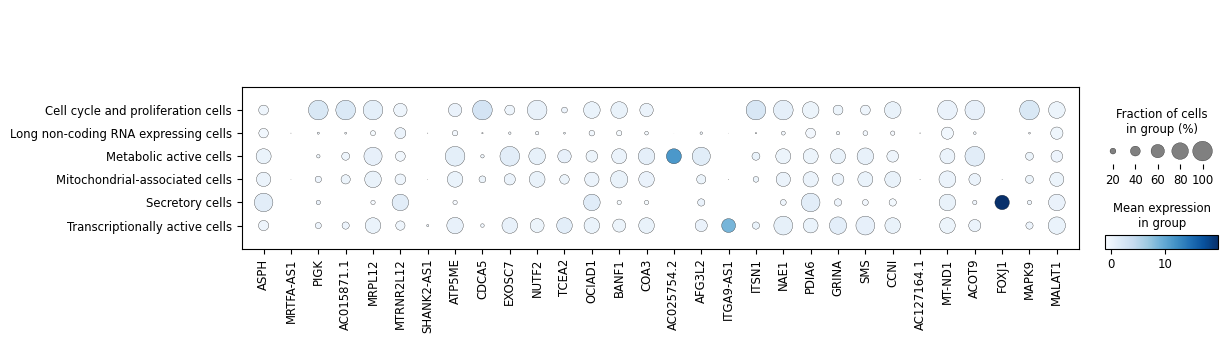

In [15]:
conversation_history = conversation_history[:8]
task10 = f"Validate the cell types by plotting expression levels of known canonical markers. Ignore any unknown cell types unable to be characterized. Determine the intersecting genes between my dataset and the canonical markers. Convert the set of intersecting genes into a list and filter my dataset with the list. Ensure the plot has all required arguments. {figures_string}"

conversation_history, response10 = get_conversation_response(role, task10, conversation_history)
exec(response10)

## Differential Expression Analysis

Identify genes that are differentially expressed between different cell populations or conditions.

In [16]:
task11 = f"Calculate differential expression, using an appropriate method. Output the top differentially expressed genes for each cell type and sample in a DataFrame, including the score and adjusted p-values. Generate column names dynamically. {dataframes_string}"

conversation_history, response11 = get_conversation_response(role, task11, conversation_history)
exec(response11)

import pandas as pd
import scanpy as sc

# Define the number of top differentially expressed genes to keep
top_n_de_genes = 10

# Calculate differential expression
sc.tl.rank_genes_groups(merged, groupby='Cell Type', method='t-test_overestim_var')

# Initialize an empty dictionary to store the results
de_results = {}

# Loop over each cell type and get the top differentially expressed genes
for cell_type in merged.obs['Cell Type'].unique():
    cell_type_marker_genes = pd.DataFrame(merged.uns['rank_genes_groups']['names'][cell_type])[:top_n_de_genes]
    cell_type_marker_scores = pd.DataFrame(merged.uns['rank_genes_groups']['scores'][cell_type])[:top_n_de_genes]
    cell_type_marker_pvals = pd.DataFrame(merged.uns['rank_genes_groups']['pvals_adj'][cell_type])[:top_n_de_genes]
    
    # Combine the marker genes, scores, and p-values into a single DataFrame
    cell_type_de_results = pd.concat([cell_type_marker_genes, cell_type_marker_scores, cell_type_marker_pvals], axis=1)
    cell_ty